<a href="https://colab.research.google.com/github/mphani/ts_prophet/blob/works/actual_as_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

from tabulate import tabulate

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.plot import plot_plotly, plot_components_plotly

from sklearn.preprocessing import StandardScaler

from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


In [145]:
G_FILENAME = "sample_data/24122023_aerospike_stats.csv"

In [ ]:
original_df = pd.read_csv(G_FILENAME)
original_df.head()

In [ ]:
l_sort_column_names = ["utc_date_time"]
original_df.sort_values(by= l_sort_column_names, ascending = True)

In [148]:
original_df["date_from_utc"] = pd.to_datetime(original_df.utc_date_time , unit='s')
original_df["full_date"] = original_df["date_from_utc"].dt.date
original_df["year"] = original_df["date_from_utc"].dt.year
original_df["month"] = original_df["date_from_utc"].dt.month
original_df["day"] = original_df["date_from_utc"].dt.day
original_df["hour"] = original_df["date_from_utc"].dt.hour
original_df["minute"] = original_df["date_from_utc"].dt.minute
original_df["second"] = original_df["date_from_utc"].dt.second

In [149]:
print( original_df.shape)

(419622, 17)


In [150]:
read_df= original_df[ original_df.metric_name=="aerospike_namespace_client_read_success"]
#read_df= read_df[ read_df.sub_query_name=="simple_query"]
read_df= read_df[ read_df.sub_query_name=="rate_query"]
# pick up only ssd namespace
read_df= read_df[ read_df.ns=="ssd" ]
# read_df= read_df[ (read_df.ns=="ssd") & (read_df.service=="192.168.201.241:3000")]
read_df.shape

(69919, 17)

In [151]:
read_df= read_df[ read_df.service=="192.168.201.241:3000"]
read_df.shape

(23306, 17)

In [152]:
# standardize the prophet_read_df values
scaler = StandardScaler()
read_df["y"] = scaler.fit_transform(read_df[["metric_value"]])
read_df.shape

(23306, 18)

In [153]:
read_df["full_date"].value_counts()

2023-12-19    1440
2023-12-16    1440
2023-12-09    1440
2023-12-08    1440
2023-12-10    1440
2023-12-13    1440
2023-12-20    1440
2023-12-12    1440
2023-12-22    1440
2023-12-21    1440
2023-12-18    1440
2023-12-17    1440
2023-12-15    1440
2023-12-14    1440
2023-12-11    1438
2023-12-23    1107
2023-12-07     359
2023-12-24     242
Name: full_date, dtype: int64

In [154]:
print(read_df["service"].unique())
print(read_df["ns"].unique())
print(read_df["cluster_name"].unique())
print(read_df["metric_name"].unique())
print((read_df["full_date"].unique()))

['192.168.201.241:3000']
['ssd']
['numa']
['aerospike_namespace_client_read_success']
[datetime.date(2023, 12, 19) datetime.date(2023, 12, 20)
 datetime.date(2023, 12, 14) datetime.date(2023, 12, 15)
 datetime.date(2023, 12, 17) datetime.date(2023, 12, 18)
 datetime.date(2023, 12, 21) datetime.date(2023, 12, 22)
 datetime.date(2023, 12, 16) datetime.date(2023, 12, 12)
 datetime.date(2023, 12, 13) datetime.date(2023, 12, 10)
 datetime.date(2023, 12, 11) datetime.date(2023, 12, 23)
 datetime.date(2023, 12, 24) datetime.date(2023, 12, 8)
 datetime.date(2023, 12, 9) datetime.date(2023, 12, 7)]


In [155]:
# DATE wise train / test split
#
max_date = read_df["full_date"].max()
print( max_date)

2023-12-24


In [156]:
max_date = datetime.datetime.strptime("2023-12-21", '%Y-%m-%d')
max_date = max_date.date()
train_read_df= read_df[ read_df.full_date<max_date]
train_read_df.shape

(19077, 18)

In [157]:
test_read_df= read_df[ read_df.full_date>=max_date]
test_read_df.shape

(4229, 18)

In [158]:
# check if max-date (24/Dec/2023 ) is filtered / removed from train set
#
train_read_df["full_date"].value_counts()

2023-12-19    1440
2023-12-20    1440
2023-12-14    1440
2023-12-15    1440
2023-12-17    1440
2023-12-18    1440
2023-12-16    1440
2023-12-12    1440
2023-12-13    1440
2023-12-10    1440
2023-12-08    1440
2023-12-09    1440
2023-12-11    1438
2023-12-07     359
Name: full_date, dtype: int64

In [159]:
# read_df["full_date", "metric_value"].plot()
# prophet_read_df = train_read_df[ ["date_from_utc", "metric_value"] ].copy()
prophet_read_df = train_read_df[ ["date_from_utc", "y"] ].copy()
prophet_read_df['date_from_utc'] = pd.to_datetime(prophet_read_df['date_from_utc'], format='%Y-%m-%d %H:%M:%S')


In [192]:
prophet_read_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
# prophet_read_df=prophet_read_df.reset_index()
prophet_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19077 entries, 5760 to 418181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      19077 non-null  datetime64[ns]
 1   y       19077 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 447.1 KB


In [193]:
prophet_read_df

ds         y
5760   2023-12-19 18:30:00 -0.224532
5761   2023-12-19 18:31:00 -0.057775
5762   2023-12-19 18:32:00 -0.121128
5763   2023-12-19 18:33:00  0.050232
5764   2023-12-19 18:34:00 -0.073246
...                    ...       ...
418177 2023-12-10 18:25:00 -0.640380
418178 2023-12-10 18:26:00 -0.510781
418179 2023-12-10 18:27:00 -0.557002
418180 2023-12-10 18:28:00 -0.555531
418181 2023-12-10 18:29:00 -0.583007

[19077 rows x 2 columns]

In [195]:
test_read_df["y"]

107456    1.440853
107457    1.449822
107458    1.501501
107459    1.377596
107460    1.455849
            ...   
307642   -0.599237
307643   -0.859385
307644   -0.867310
307645   -0.839928
307646   -3.095287
Name: y, Length: 4229, dtype: float64

In [162]:
l_sort_column_names = ["ds"]
prophet_read_df.sort_values(by= l_sort_column_names, ascending = True)
print( "len(prophet_read_df) ==> ", len(prophet_read_df))

len(prophet_read_df) ==>  19077


In [163]:
# Removing duplicates in the original DataFrame
prophet_read_df.drop_duplicates(subset="ds", inplace=True)


<Axes: >

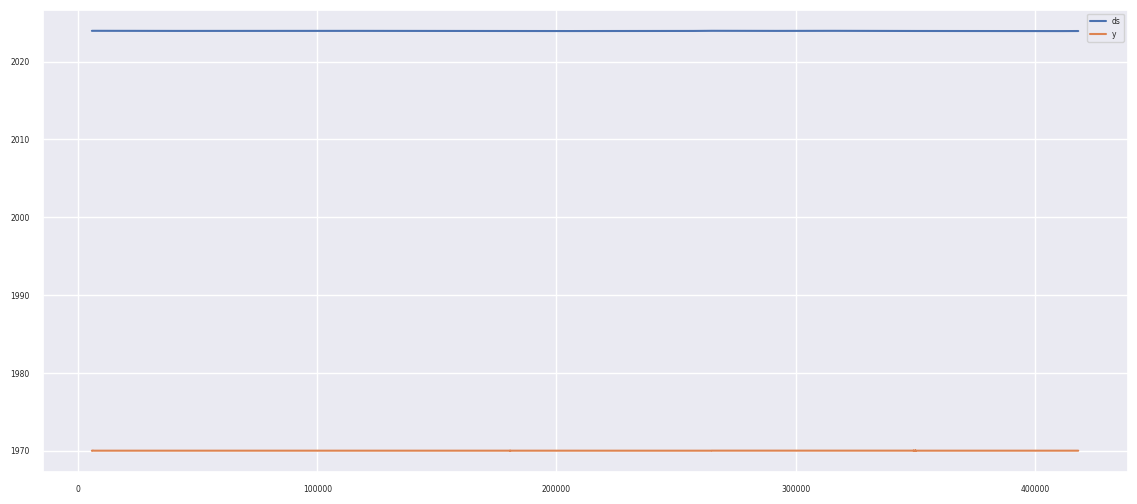

In [164]:
prophet_read_df.plot()

<Axes: xlabel='ds', ylabel='y'>

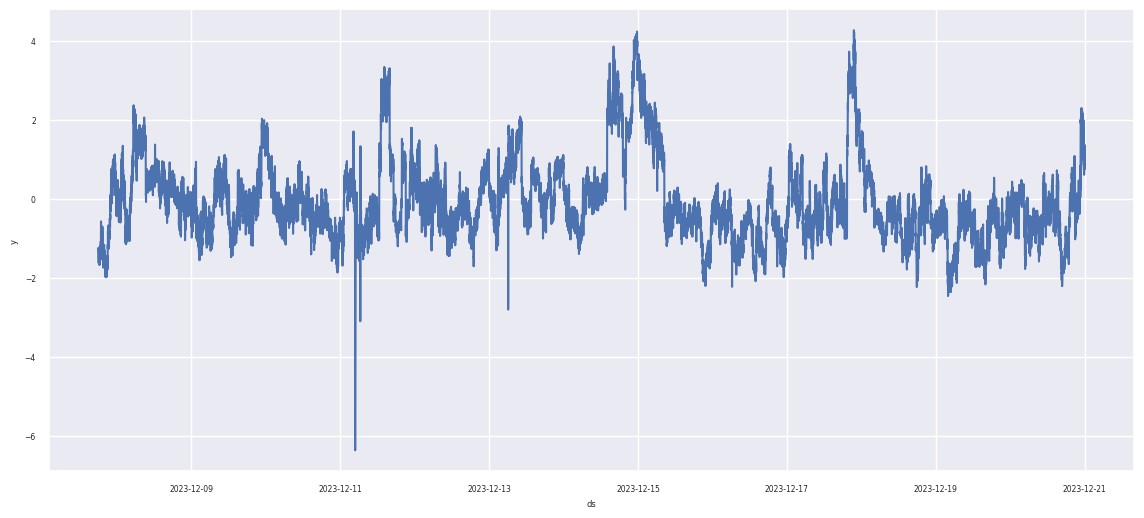

In [165]:
sns.set(rc={ "figure.figsize":(14,6) }, font_scale=0.5, style="darkgrid")
sns.lineplot( data=prophet_read_df, x="ds", y="y" )

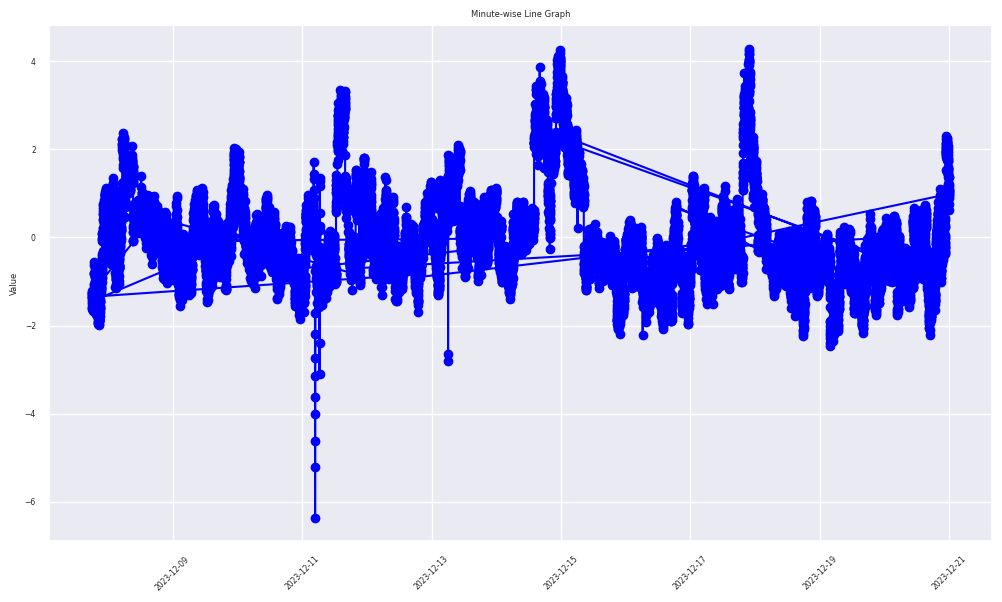

In [166]:

# Plotting a line graph
plt.figure(figsize=(10, 6))  # Set figure size as needed

plt.plot(prophet_read_df['ds'], prophet_read_df['y'], color='blue', marker='o', linestyle='-')

# plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [ ]:
# Plotting a line graph
plt.figure(figsize=(14, 6))  # Set figure size as needed

single_day_df = train_read_df [ train_read_df.day == 15 ]

single_day_df = single_day_df[ ["date_from_utc", "metric_value"] ].copy()
single_day_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
single_day_df.info()

# plt.plot(single_day_df['ds'], single_day_df['y'], color='green', marker='o', linestyle='--')
plt.bar (single_day_df['ds'], single_day_df['y'], )


plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [167]:
m = Prophet()
# m= Prophet( interval_width=0.9, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True )
m.fit(prophet_read_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpweuzq6vz/lpagni4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpweuzq6vz/1xl5wgxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40748', 'data', 'file=/tmp/tmpweuzq6vz/lpagni4h.json', 'init=/tmp/tmpweuzq6vz/1xl5wgxp.json', 'output', 'file=/tmp/tmpweuzq6vz/prophet_model0o1i98x7/prophet_model-20231226111831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [168]:
# 1440 = 24 * 60 minutes
# 4320 = 1440 * 3 days

#
future = m.make_future_dataframe(periods= len(test_read_df), freq="T", include_history= True)
future


ds
0     2023-12-07 18:01:00
1     2023-12-07 18:02:00
2     2023-12-07 18:03:00
3     2023-12-07 18:04:00
4     2023-12-07 18:05:00
...                   ...
23301 2023-12-23 22:24:00
23302 2023-12-23 22:25:00
23303 2023-12-23 22:26:00
23304 2023-12-23 22:27:00
23305 2023-12-23 22:28:00

[23306 rows x 1 columns]

In [169]:
forecast = m.predict( future)
#
# only for anamoly
# forecast = m.predict( prophet_read_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23306 entries, 0 to 23305
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          23306 non-null  datetime64[ns]
 1   trend                       23306 non-null  float64       
 2   yhat_lower                  23306 non-null  float64       
 3   yhat_upper                  23306 non-null  float64       
 4   trend_lower                 23306 non-null  float64       
 5   trend_upper                 23306 non-null  float64       
 6   additive_terms              23306 non-null  float64       
 7   additive_terms_lower        23306 non-null  float64       
 8   additive_terms_upper        23306 non-null  float64       
 9   daily                       23306 non-null  float64       
 10  daily_lower                 23306 non-null  float64       
 11  daily_upper                 23306 non-null  float64   

<Axes: xlabel='ds'>

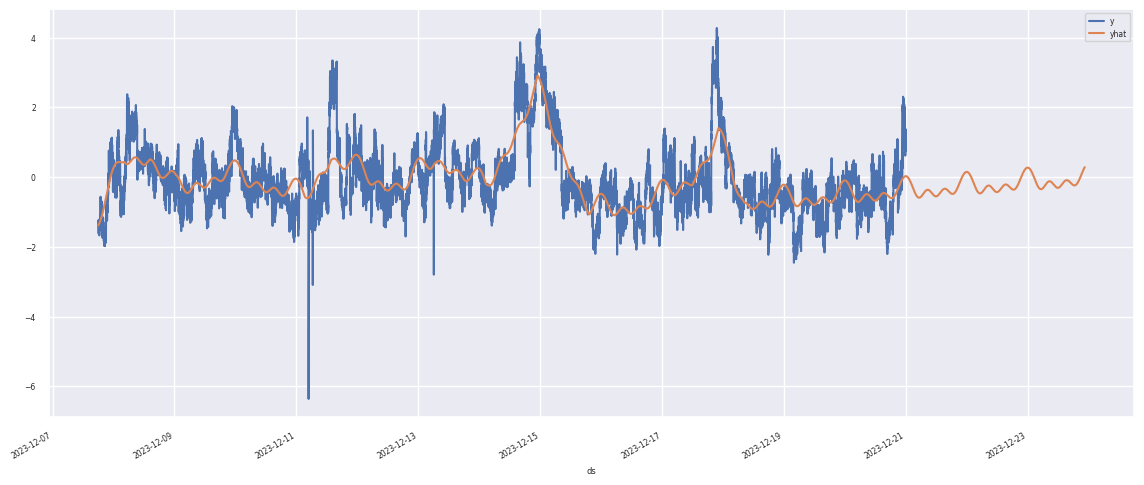

In [171]:
pd.concat( [prophet_read_df.set_index("ds")["y"],  forecast.set_index("ds")["yhat"]], axis=1).plot()

In [172]:
# merge original and forecasted
#
temp_test_read_df = test_read_df.copy()
temp_test_read_df.rename(columns={"date_from_utc": "ds" }, inplace=True)
merged_df = pd.merge( temp_test_read_df, forecast[["ds", "yhat","yhat_lower","yhat_upper"]], on="ds" )

<Axes: xlabel='ds'>

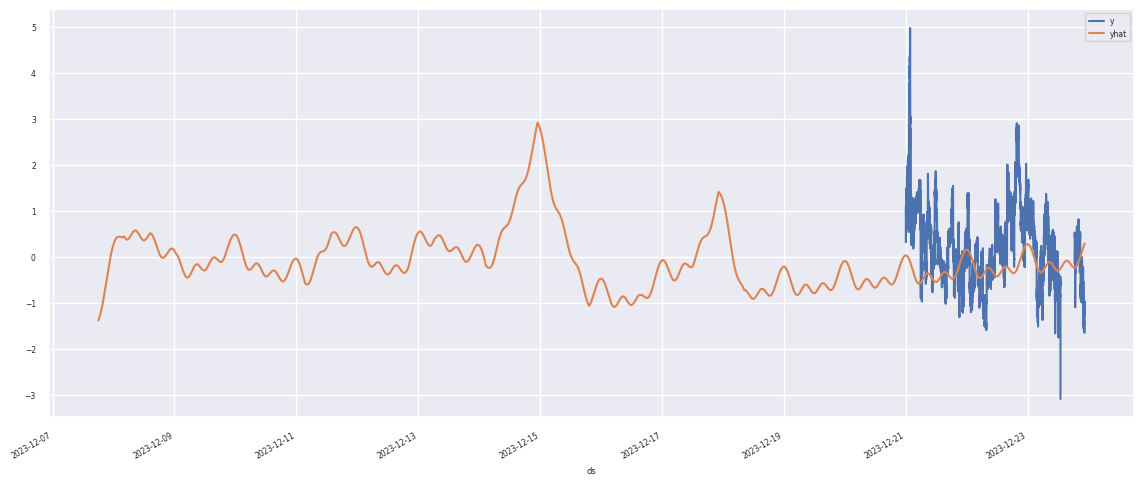

In [173]:
pd.concat( [merged_df.set_index("ds")["y"],  forecast.set_index("ds")["yhat"]], axis=1).plot()

In [174]:
merged_df.to_csv("prophet_forecasted.csv")

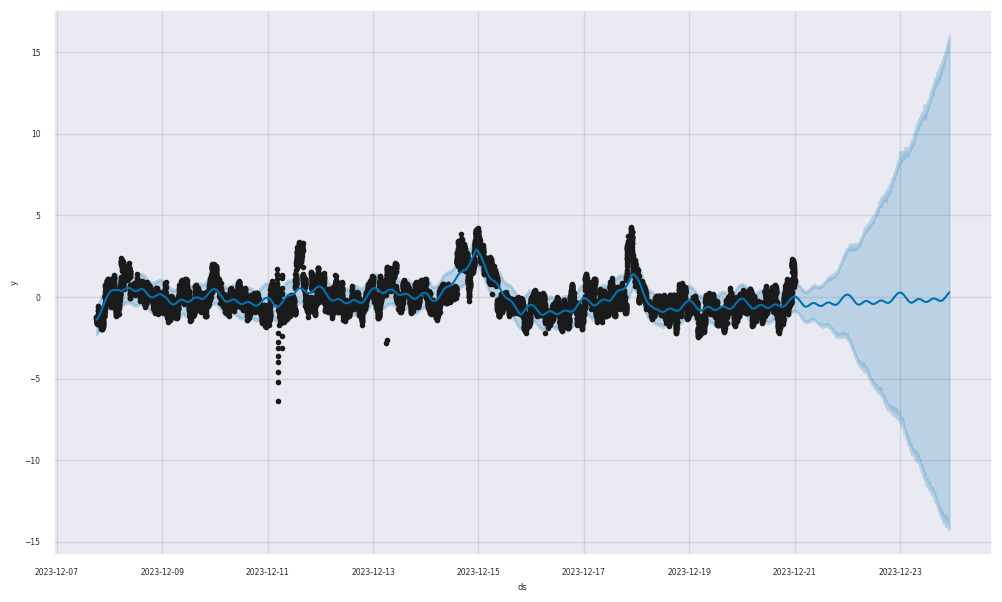

In [175]:
figure_1 = m.plot(forecast)


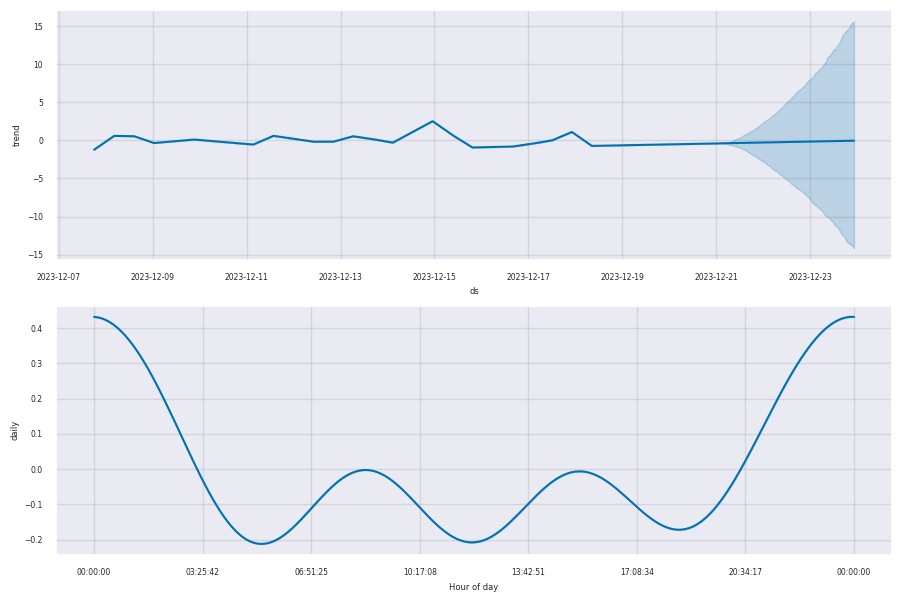

In [176]:
figure_2 = m.plot_components(forecast)

In [177]:
plot_plotly(m, forecast)

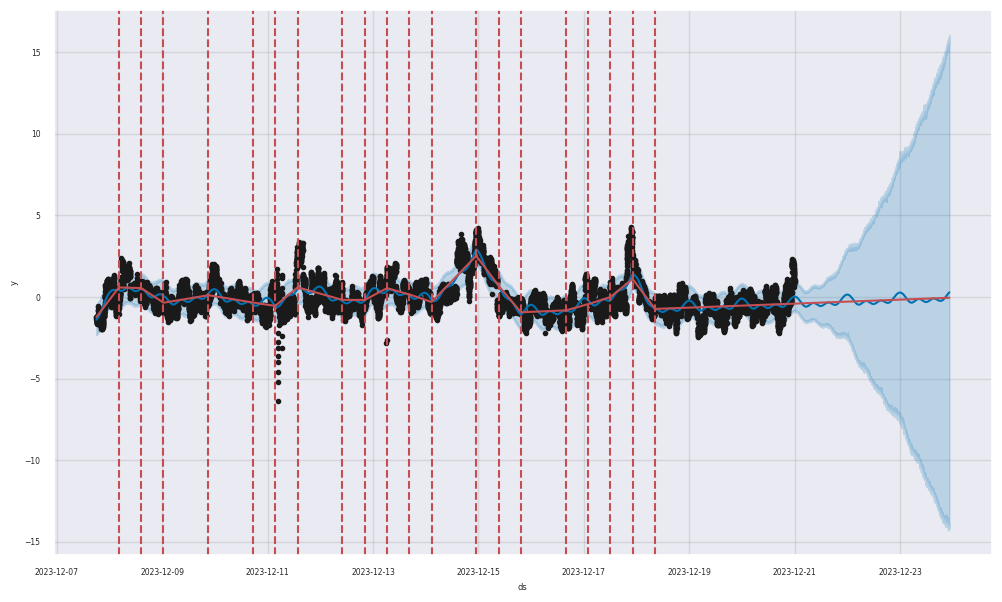

In [178]:
fig_change_points = add_changepoints_to_plot ( figure_1.gca(), m, forecast)
figure_1

In [ ]:
merged_df.info()

In [179]:
temp_y_pref = forecast[ forecast.ds >= max_date.ctime() ]
# temp_y_pref

In [190]:
y_true = test_read_df["y"].values


MAE: 0.747


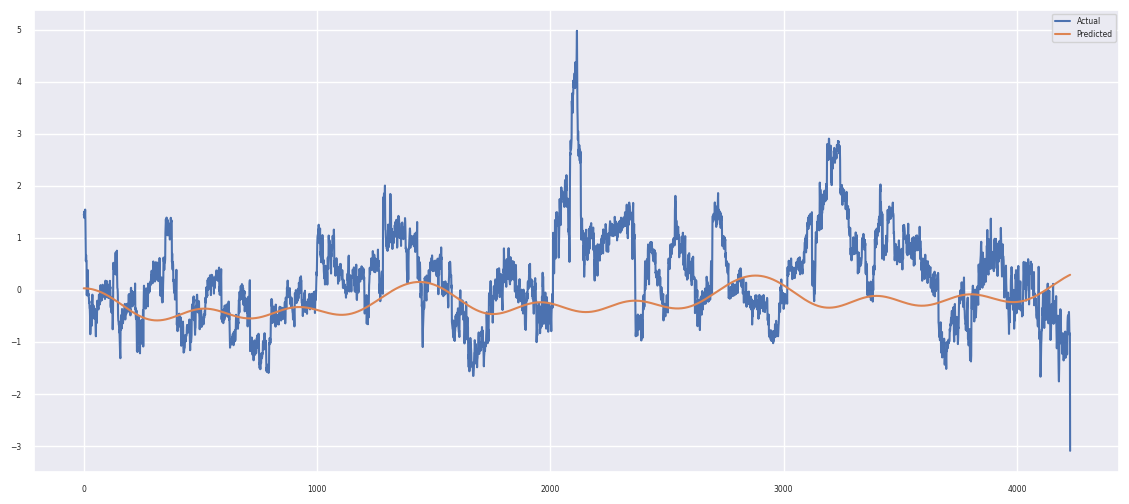

In [191]:

y_pred = temp_y_pref['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [182]:
# error and metrics
perf_mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
print ("mae ", perf_mae)
perf_mape = mean_absolute_percentage_error(merged_df['y'], merged_df['yhat'])
print("mape " , perf_mape )

mae  0.7633054617048004
mape  2.401231578131581


In [183]:
merged_df["anomaly"] = merged_df.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
merged_df["anomaly"].value_counts()

0    3404
1     492
Name: anomaly, dtype: int64

In [ ]:
anomalies_df = merged_df[ merged_df["anomaly"]==1].sort_values(by='ds')
anomalies_df.head(100)

<Axes: xlabel='ds', ylabel='y'>

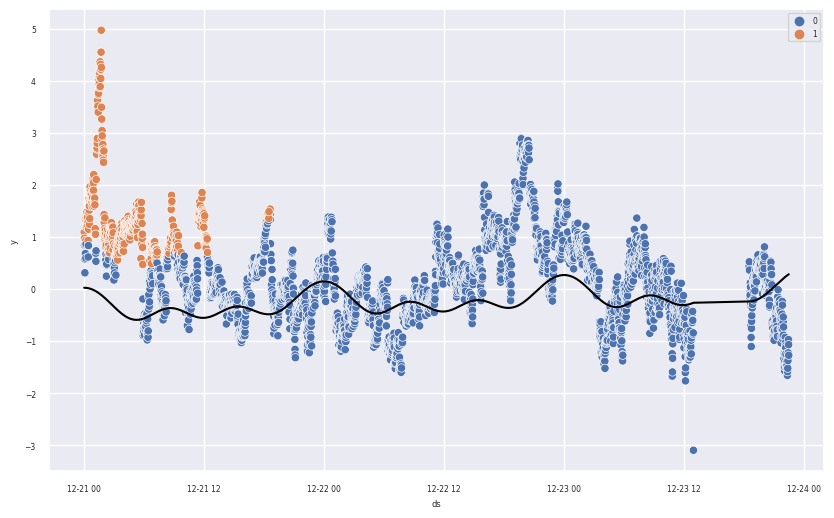

In [185]:
# Visualize the anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ds", y="y", data=merged_df, hue="anomaly")
sns.lineplot(x="ds", y="yhat", data=merged_df, color="black")

In [186]:
# Calculate residuals (difference between actual and predicted values)
merged_df['residuals'] = merged_df['y'] - merged_df['yhat']

merged_df.info()

# single_merged_df =


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3896 entries, 0 to 3895
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cluster_name    3896 non-null   object        
 1   instance        3896 non-null   object        
 2   ns              3896 non-null   object        
 3   service         3896 non-null   object        
 4   metric_name     3896 non-null   object        
 5   sub_query_name  3896 non-null   object        
 6   prom_query      3896 non-null   object        
 7   utc_date_time   3896 non-null   int64         
 8   metric_value    3896 non-null   float64       
 9   ds              3896 non-null   datetime64[ns]
 10  full_date       3896 non-null   object        
 11  year            3896 non-null   int64         
 12  month           3896 non-null   int64         
 13  day             3896 non-null   int64         
 14  hour            3896 non-null   int64         
 15  minu

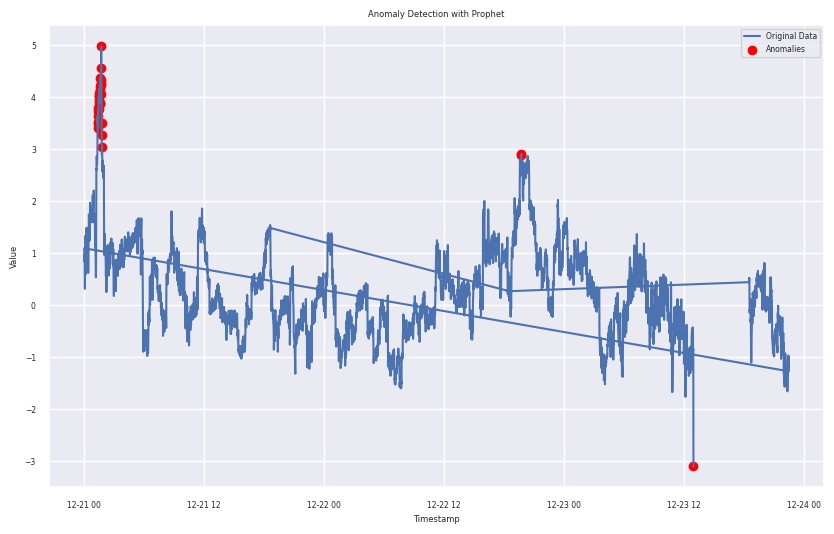

In [187]:
# Calculate mean and standard deviation of residuals
mean_residual = merged_df['residuals'].mean()
std_residual = merged_df['residuals'].std()

# Set a threshold for anomalies (e.g., 3 standard deviations)
threshold = 3 * std_residual

# Identify anomalies
anomalies = merged_df[np.abs(merged_df['residuals'] - mean_residual) > threshold]

# Plotting the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Original Data')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection with Prophet')
plt.show()

In [ ]:
perf_cv = cross_validation(m, initial='6 days', period='2 days', horizon = '1 days')

In [ ]:
perf_cv_metrics = performance_metrics( perf_cv)
perf_cv_metrics.info()

perf_cv_metrics

In [ ]:
fig = plot_cross_validation_metric(perf_cv, metric='mape')